In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import os
import warnings
from scipy.sparse import vstack
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix
import re
from tqdm import tqdm
from collections import Counter
from openai import OpenAI
from sklearn.model_selection import train_test_split
import umap
import ast


In [2]:
def get_transition_matrix_efficient(df, word_to_index, d):
    transition_counts = np.ones((d, d), dtype=int)
    for utterance in df['utterance']:
        if type(utterance) != str:
            try:
                utterance = str(utterance)
            except:
                continue
        words = utterance.split()
        for i in range(1, len(words)):
            word1 = words[i - 1]
            word2 = words[i]
            if word1 in word_to_index and word2 in word_to_index:
                index1 = word_to_index[word1]
                index2 = word_to_index[word2]
                transition_counts[index2, index1] += 1
    column_sums = transition_counts.sum(axis=0, keepdims=True)
    transition_probabilities = transition_counts / column_sums
    return transition_probabilities, word_to_index

def tensor_trouble(df, word_to_index, d):
    tensor = np.ones((d, 2, 2), dtype=int)
    for episode, group in df.groupby('episode'):
        if type(group['utterance']) != str:
            group['utterance'] = group['utterance'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
        text = " ".join(group['utterance'].astype(str))
        words = text.split()
        roles = np.concatenate(group.apply(lambda row: [row['is_host']] * len(str(row['utterance']).split()), axis=1).values)
        for i in range(2, len(words)):
            word = words[i - 2]
            if word not in word_to_index:  # Check if the word exists in the dictionary
                continue  # Skip this iteration if the word is not found
            next_role = roles[i - 1]
            following_role = roles[i]
            current_index = word_to_index[word]
            current_role_index = 0 if next_role else 1
            next_role_index = 0 if following_role else 1
            tensor[current_index, next_role_index, current_role_index] += 1
    return tensor, word_to_index

def make_emission(host, guest):
    emission = np.zeros((len(host), len(host), 2))
    emission[:, :, 0] = host
    emission[:, :, 1] = guest
    return np.swapaxes(emission, 0, 1)

def tensor_viterbi(obs, transition, emission, initial):
    b_eps = 1e-25
    start_index = obs[0]
    obs = obs[1:]
    n = len(obs)
    d = transition.shape[0]
    eta = np.zeros((n, 2))
    backpointers = np.zeros((n, 2), dtype=int)
    eta[0] = np.log(initial) + np.log(emission[start_index, obs[1], :])
    obs = obs[1:]
    for i in range(1, n - 1):
        b = emission[obs[i - 1], obs[i], :]
        if np.any(b == 0):
            zero_index = np.where(b == 0)
            b[zero_index] = b_eps
        eta_candidate = np.log(transition[obs[i - 1], :, :]) + np.log(b)[:, np.newaxis] + eta[i - 1][np.newaxis, :]
        eta[i] = np.max(eta_candidate, axis=1)
        backpointers[i] = np.argmax(eta_candidate, axis=1)
    state_sequence = np.zeros(n, dtype=int)
    state_sequence[-1] = np.argmax(eta[-1])
    for i in range(n - 2, -1, -1):
        state_sequence[i] = backpointers[i + 1, state_sequence[i + 1]]
    return state_sequence

def pad_to_match(a, b):
    """
    Pads the shorter array with its last element to match the length of the longer array.
    
    Args:
        a (np.array): First array for comparison.
        b (np.array): Second array for comparison.
        
    Returns:
        np.array, np.array: The two arrays modified to have equal lengths.
    """
    if len(a) == len(b):
        return a, b
    elif len(a) > len(b):
        padding = np.full(len(a) - len(b), b[-1])
        b_padded = np.concatenate((b, padding))
        return a, b_padded
    else:
        padding = np.full(len(b) - len(a), a[-1])
        a_padded = np.concatenate((a, padding))
        return a_padded, b

In [ ]:


warnings.filterwarnings("ignore")
def aggressive_cleaning(text):
    """
    Cleans the text by handling NaN values and 'nan' strings, normalizing dashes, lowercasing,
    and removing non-alphabetic characters except spaces.
    """
    text = str(text)
    if text.lower() == 'nban' or pd.isna(text):
        return ''
    else:
        text = text.replace('-', ' ').lower().strip()
        text = re.sub(r'[^a-z\s]', '', text)
        return text

def tokenize(text):
    """
    Tokenizes and lemmatizes the given text, applying a word frequency filter.
    Words below the threshold are replaced with 'xxxxx'.
    """
    words = text.split()
    filtered_tokens = [word for word in words if word not in string.punctuation]
    return ' '.join(filtered_tokens)

def preprocess_and_compile_episodes(dataframe):
    """
    Applies preprocessing to the entire DataFrame, then compiles text into episodes,
    with each row corresponding to an episode's aggregated utterances.
    """
    tqdm.pandas(desc="Aggressive cleaning")
    dataframe['utterance'] = dataframe['utterance'].progress_apply(aggressive_cleaning)
    
    tqdm.pandas(desc="Tokenizing")
    dataframe['utterance'] = dataframe['utterance'].progress_apply(tokenize)
    
    tqdm.pandas(desc="Compiling Episodes")
    compiled_episodes = dataframe.groupby('episode')['utterance'].apply(' '.join).reset_index()
    
    return compiled_episodes

episode_df = preprocess_and_compile_episodes(df)
episode_df.to_csv('archive/compiled_episodes.csv', index=False)
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

episode_df['embedding'] = episode_df['utterance'].apply(lambda x: get_embedding(x, model='text-embedding-3-small'))
# save the embeddings as a numpy array
episode_df.to_parquet('archive/episode_embeddings.parquet', compression='snappy')
# save as numpy array
embeddings = np.array(episode_df['embedding'].tolist())
np.save('archive/episode_embeddings.npy', embeddings)

In [6]:
df = pd.read_csv('archive/utterances-2sp.csv')

# save as pandas dataframe
episode_df = pd.read_csv('archive/episode_embeddings.csv')
# Filter the original dataframe to include only rows where 'is_host' is True
hosts_df = df[df['is_host'] == True]

# Since each episode has a single host, we can drop duplicates to avoid repetition
hosts_df = hosts_df[['episode', 'host_id']].drop_duplicates()

# Ensure the 'episode' column is of the same type in both dataframes to avoid merge issues
hosts_df['episode'] = hosts_df['episode'].astype(str)

# Ensure the 'episode' column in embed_df is of type string, matching hosts_df
episode_df['episode'] = episode_df['episode'].astype(str)

# Merge the dataframes on the 'episode' column
embed_df_with_hosts = episode_df.merge(hosts_df, on='episode', how='left')

# Now embed_df_with_hosts contains the embeddings with the corresponding host_id for each episode

embed_df_with_hosts.to_csv('archive/embed_df_with_hosts.csv', index=False)
# select 10 different hosts
host_ids = embed_df_with_hosts['host_id'].unique()[:10]

In [54]:
# filter the dataframe to include only the selected hosts
my_df = embed_df_with_hosts[embed_df_with_hosts['host_id'].isin(host_ids)]
X, y = my_df['embedding'].values, my_df['host_id'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Convert the lists of floats into numpy arrays
X_train = np.array([np.array(x) for x in X_train])
X_test = np.array([np.array(x) for x in X_test])

embedding = umap.UMAP().fit_transform(X_train)
# embedding = umap.UMAP().fit_transform(X_train, y_train)
fig = plt.figure(figsize=(8, 4), dpi=750)
plt.scatter(*embedding.T, s=1, c=y_train, cmap='Spectral', alpha=1.0)
# remove the axes
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.title('UMAP projection of the embeddings')
# add colorbar
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_label('Host ID', rotation=270)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(host_ids)
plt.show()

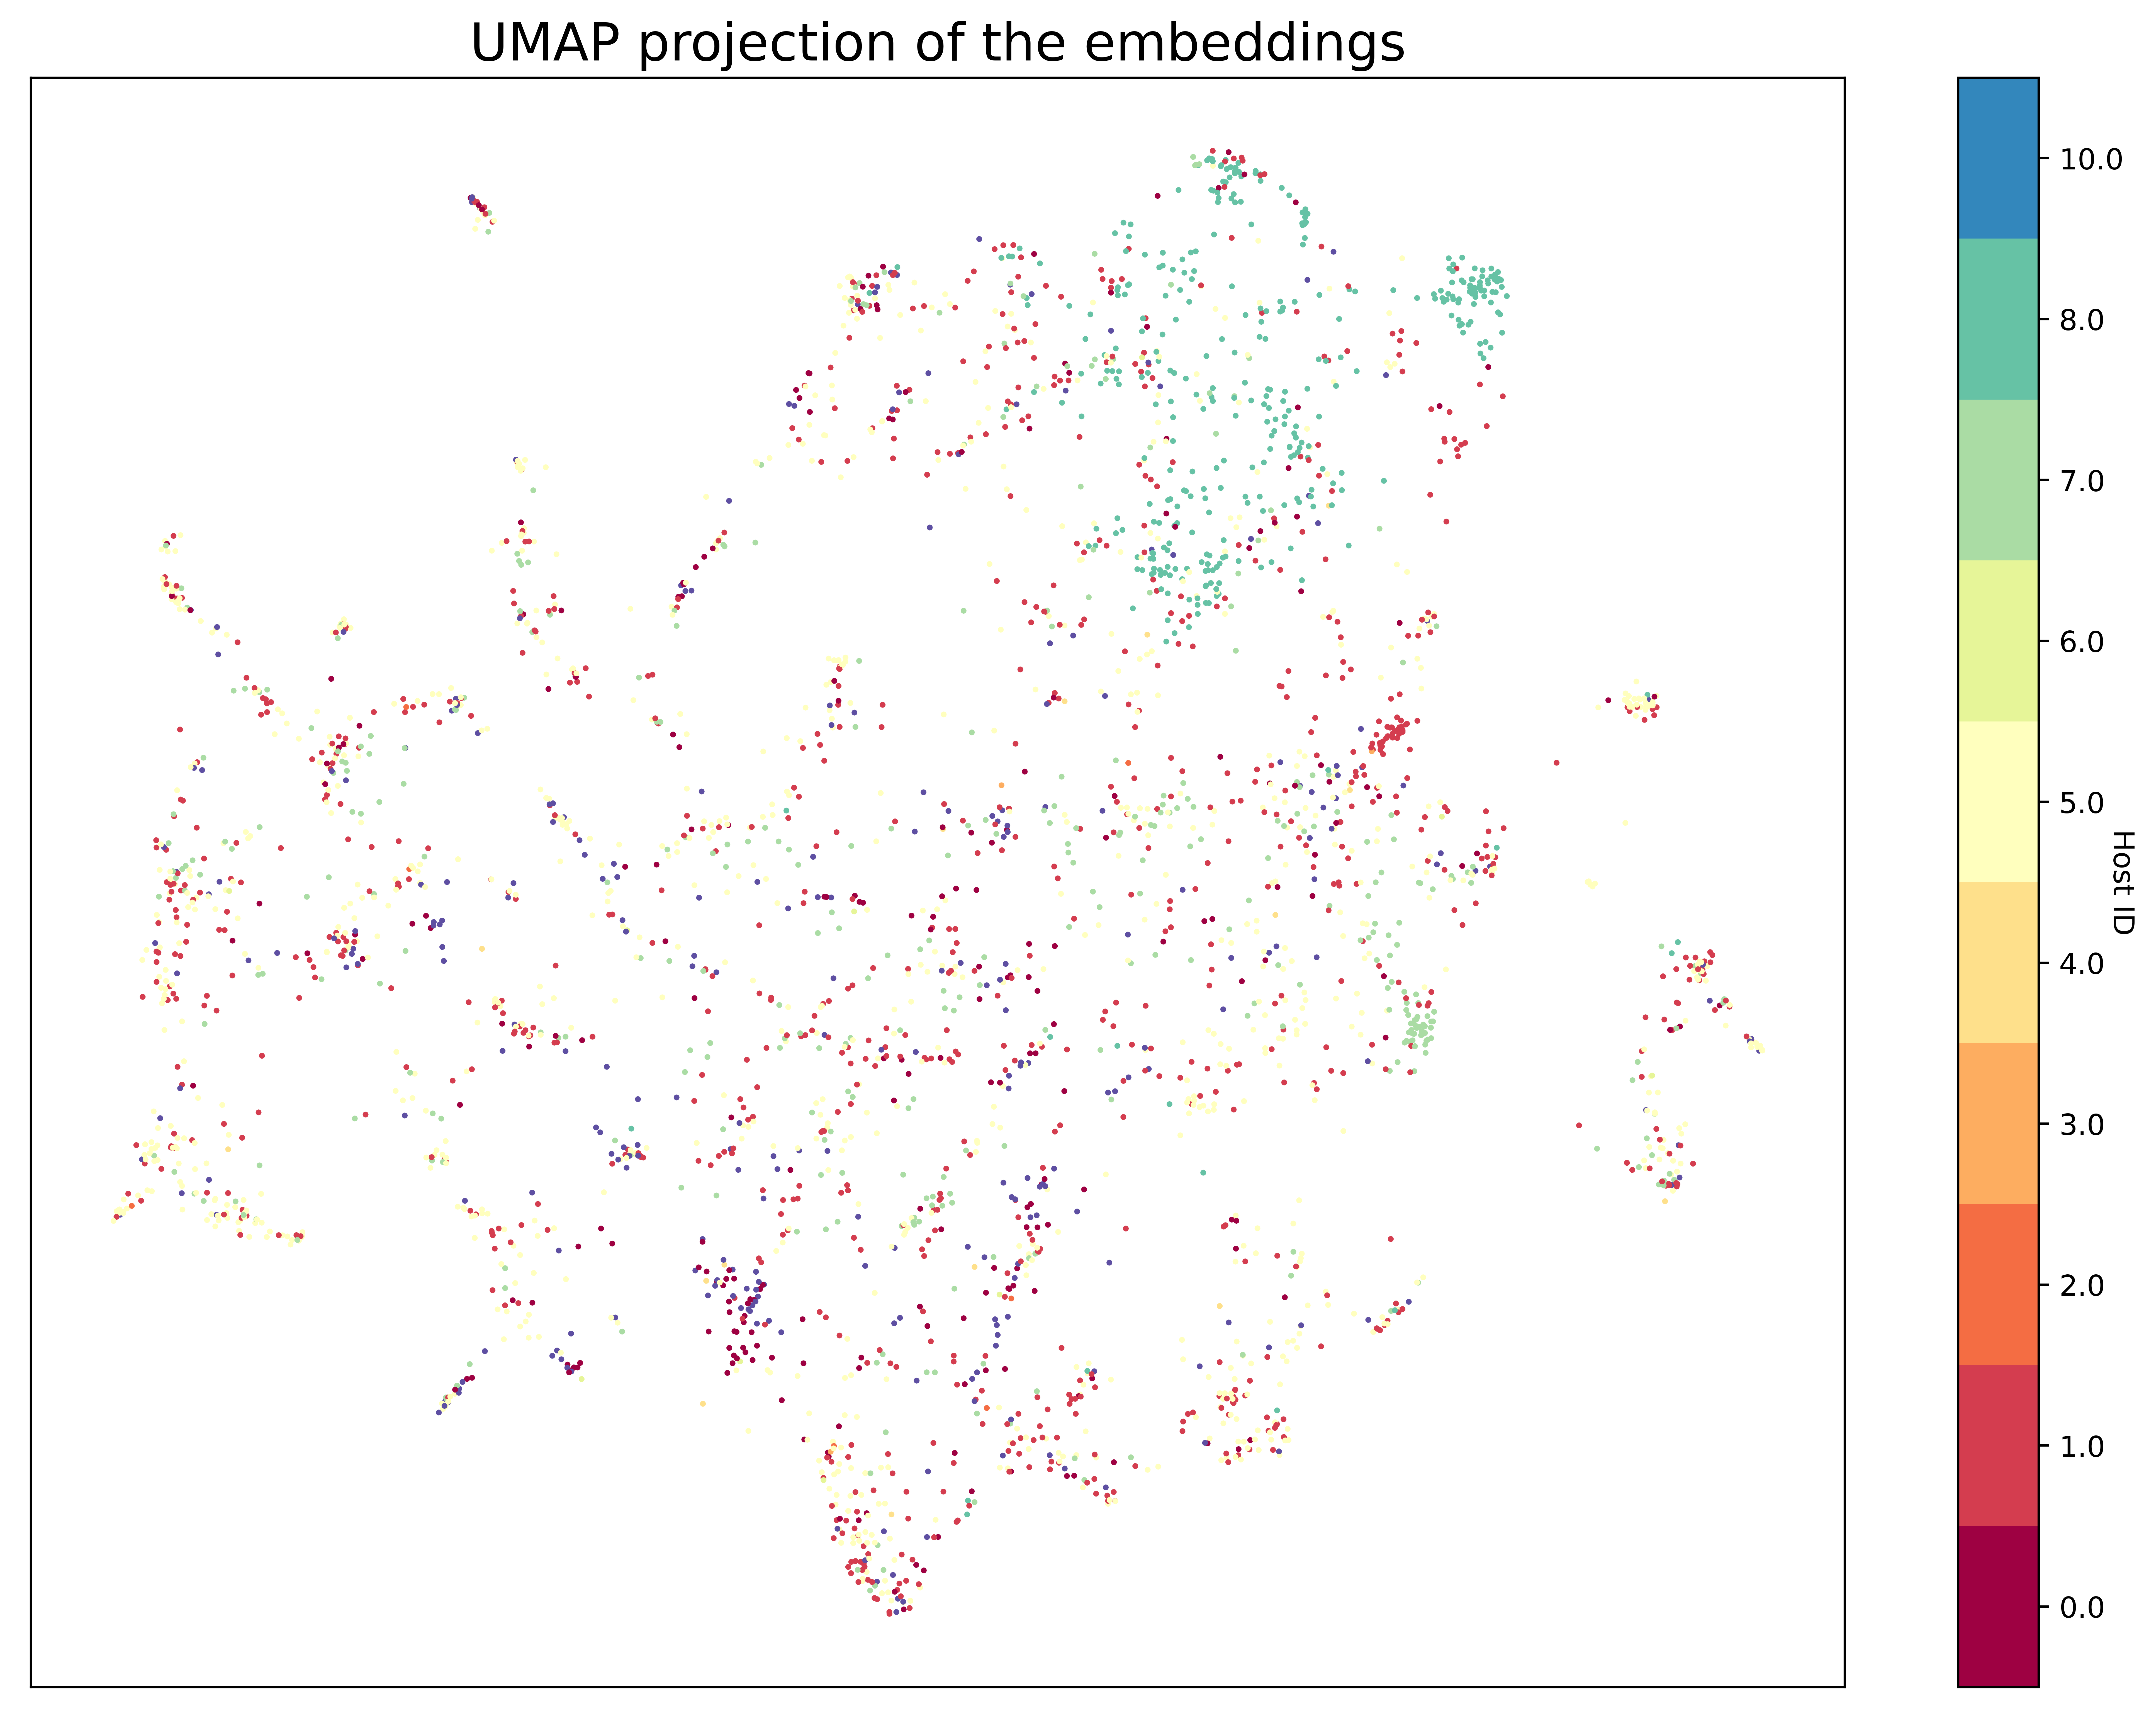

In [32]:
embedding = umap.UMAP().fit_transform(X_train)
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=750)
plt.scatter(*embedding.T, s=1, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('UMAP projection of the embeddings', fontsize=18)
# add colorbar
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_label('Host ID', rotation=270)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(host_ids)
plt.show()

In [91]:
hosts_df = df[df['is_host'] == True]

# Since each episode has a single host, we can drop duplicates to avoid repetition
hosts_df = hosts_df[['episode', 'host_id']].drop_duplicates()

host_ids = hosts_df['host_id'].unique()

len(host_ids)

117

In [7]:
embed_df_with_hosts = pd.read_csv('archive/embed_df_with_hosts.csv')

# get the host_ids that have at least 100 episodes
host_ids = embed_df_with_hosts['host_id'].value_counts()[embed_df_with_hosts['host_id'].value_counts() > 100].index

embed_df_with_hosts = embed_df_with_hosts[embed_df_with_hosts['host_id'].isin(host_ids)]
# Convert the string into a list and then into an array of floats
embed_df_with_hosts['embedding'] = embed_df_with_hosts['embedding'].apply(lambda x: np.array(ast.literal_eval(x)))

<class 'pandas.core.frame.DataFrame'>
Index: 22129 entries, 0 to 23710
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   episode    22129 non-null  int64  
 1   utterance  22129 non-null  object 
 2   embedding  22129 non-null  object 
 3   host_id    22129 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 864.4+ KB


In [8]:
embed_df_with_hosts.to_csv('archive/embed_df_with_hosts_filtered.csv', index=False)


In [9]:


X, y = embed_df_with_hosts['embedding'].values, embed_df_with_hosts['host_id'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Convert the lists of floats into numpy arrays
X_train = np.array([np.array(x) for x in X_train])
X_test = np.array([np.array(x) for x in X_test])
# Reduce dimensions to 20 with UMAP
umap_reducer = umap.UMAP(n_components=20)
X_reduced = umap_reducer.fit_transform(X_train)



Testing GMM with 2 components
Tested GMM with 2 components: AIC = -758143.4611909534
Testing GMM with 12 components
Tested GMM with 12 components: AIC = -1587590.7646433134
Testing GMM with 22 components
Tested GMM with 22 components: AIC = -1837738.3141971107
Testing GMM with 32 components
Tested GMM with 32 components: AIC = -1983893.630114489
Testing GMM with 42 components
Tested GMM with 42 components: AIC = -2079502.1291090916
Testing GMM with 52 components
Tested GMM with 52 components: AIC = -2150092.423437921
Testing GMM with 62 components
Tested GMM with 62 components: AIC = -2206125.6295170635
Testing GMM with 72 components
Tested GMM with 72 components: AIC = -2247217.3218647735
Testing GMM with 82 components
Tested GMM with 82 components: AIC = -2278616.636178002
Testing GMM with 92 components
Tested GMM with 92 components: AIC = -2322428.418404634
Optimal number of components based on AIC: 92


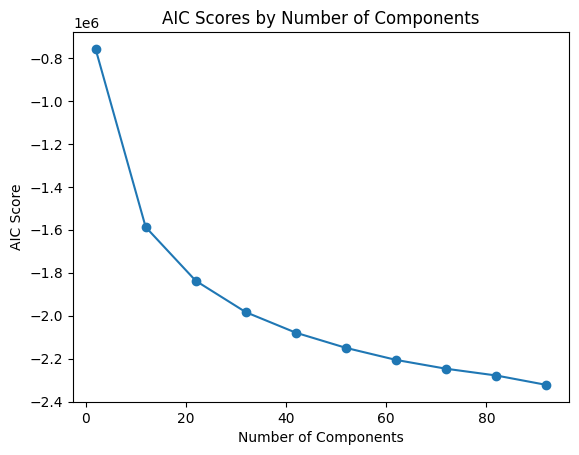

In [63]:
# Assuming X_reduced is your UMAP-reduced data ready for GMM
aic_values = []
n_components_range = range(2, 100)[::10]  # Example range from 2 to 20

for n_components in n_components_range:
    print(f"Testing GMM with {n_components} components")
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_reduced)
    aic = gmm.aic(X_reduced)
    aic_values.append(aic)
    print(f"Tested GMM with {n_components} components: AIC = {aic}")

# Identify the number of components that minimizes AIC
min_aic = min(aic_values)
optimal_n_components = n_components_range[aic_values.index(min_aic)]

print(f"Optimal number of components based on AIC: {optimal_n_components}")

# Optionally, plot the AIC values to visually inspect the tren

plt.plot(n_components_range, aic_values, marker='o')
plt.title("AIC Scores by Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("AIC Score")
plt.show()

In [10]:
# Step 2: Fit a GMM to the reduced data
# Choose the number of components based on domain knowledge or experimentation
n_components = len(host_ids)
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_reduced)

# Predict cluster labels
cluster_labels = gmm.predict(X_reduced)

In [11]:
len(cluster_labels)

17703

In [29]:
# create dictionary to map cluster labels to embeddings
cluster_to_embedding = {cluster: [] for cluster in set(cluster_labels)}
for cluster, embedding in zip(cluster_labels, X_train):
    cluster_to_embedding[cluster].append(embedding)

# create dictionary to map embeddings to episode ids
embedding_to_episode = {tuple(embedding): episode for embedding, episode in zip(embed_df_with_hosts['embedding'], embed_df_with_hosts['episode'])}

# create dictionary to map cluster labels to episoded ids
cluster_to_episode = {cluster: [] for cluster in set(cluster_labels)}
for cluster, embedding in zip(cluster_labels, X_train):
    cluster_to_episode[cluster].append(embedding_to_episode[tuple(embedding)])


In [30]:
# get a random episode from the test set
random_index = np.random.randint(len(X_test))
random_episode = X_test[random_index]

# reduce the dimensions of the random episode
random_episode_reduced = umap_reducer.transform(random_episode.reshape(1, -1))

# predict the cluster of the random episode
predicted_cluster = gmm.predict(random_episode_reduced)

In [32]:
train_episodes = cluster_to_episode[predicted_cluster[0]]

# get the episode id of the random episode
episode_id = embedding_to_episode[tuple(random_episode)]

In [33]:

filtered_df = pd.read_csv('archive/processed_utterances-2sp.csv')
filtered_df['episode'] = filtered_df['episode'].astype(str)
filtered_df['host_id'] = filtered_df['host_id'].astype(str)



In [36]:


# # load the preprocessed data
# # filtered_df = pd.read_csv('archive/most_episodes_host.csv')

# # Split each utterance into a list of words and explode the DataFrame to get a row per word
# words_series = filtered_df['utterance'].str.split().explode()
# unique_words = set(words_series)
# word_frequencies = words_series.value_counts().to_dict()
# word_indices = {word: i for i, word in enumerate(unique_words)}

# # print the number of unique words
# print(f'Number of unique words: {len(unique_words)}')

# # get the utterances associated with the training episodes
# training_episodes = set(train_episodes)
# training_df = filtered_df[filtered_df['episode'].isin(training_episodes)]


# transition_matrix_host, word_to_index_host = get_transition_matrix_efficient(filtered_df[(filtered_df['is_host'] == True) & (filtered_df['episode'].isin(train_episodes))], word_indices, len(unique_words))
# transition_matrix_guest, word_to_index_guest = get_transition_matrix_efficient(filtered_df[(filtered_df['is_host'] == False) & (filtered_df['episode'].isin(train_episodes))], word_indices, len(unique_words))
# tensor, word_to_index = tensor_trouble(filtered_df[filtered_df['episode'].isin(train_episodes)], word_indices, len(unique_words))
# tensor_normalized = tensor / (tensor.sum(axis=1, keepdims=True))

# initial = np.array([0.5, 0.5])
# emission = make_emission(transition_matrix_host, transition_matrix_guest)

# # get the index of the random episode

test_episode_df = filtered_df[filtered_df['episode'] == episode_id][['is_host', 'utterance']]
test_episode_df['utterance'] = test_episode_df['utterance'].str.split()
test_episode_df = test_episode_df.explode('utterance')
test_label = test_episode_df['is_host'].to_numpy().astype(int)
test_episode_words = ' '.join(test_episode_df['utterance'].astype(str)).split()
test_episode_words = [word for word in test_episode_words if word != 'nan']
test_episode_word_indices = [word_indices.get(word, -1) for word in test_episode_words if word in word_indices]
obs = [0] + [word_to_index[word] for word in test_episode_words if word in word_to_index]
state_sequence = tensor_viterbi(obs, tensor_normalized, emission, initial)
# print(len(state_sequence))
test_label_padded, state_sequence_padded = pad_to_match(test_label, state_sequence)

# Now, calculate the accuracy
accuracy = np.mean((state_sequence_padded == test_label_padded).astype(int))
assume_0_accuracy = np.mean((test_label_padded == 0).astype(int))
accuracy = max(accuracy, 1 - accuracy)  # Adjust based on expected behavior
assume_0_accuracy = max(assume_0_accuracy, 1 - assume_0_accuracy)





IndexError: list index out of range

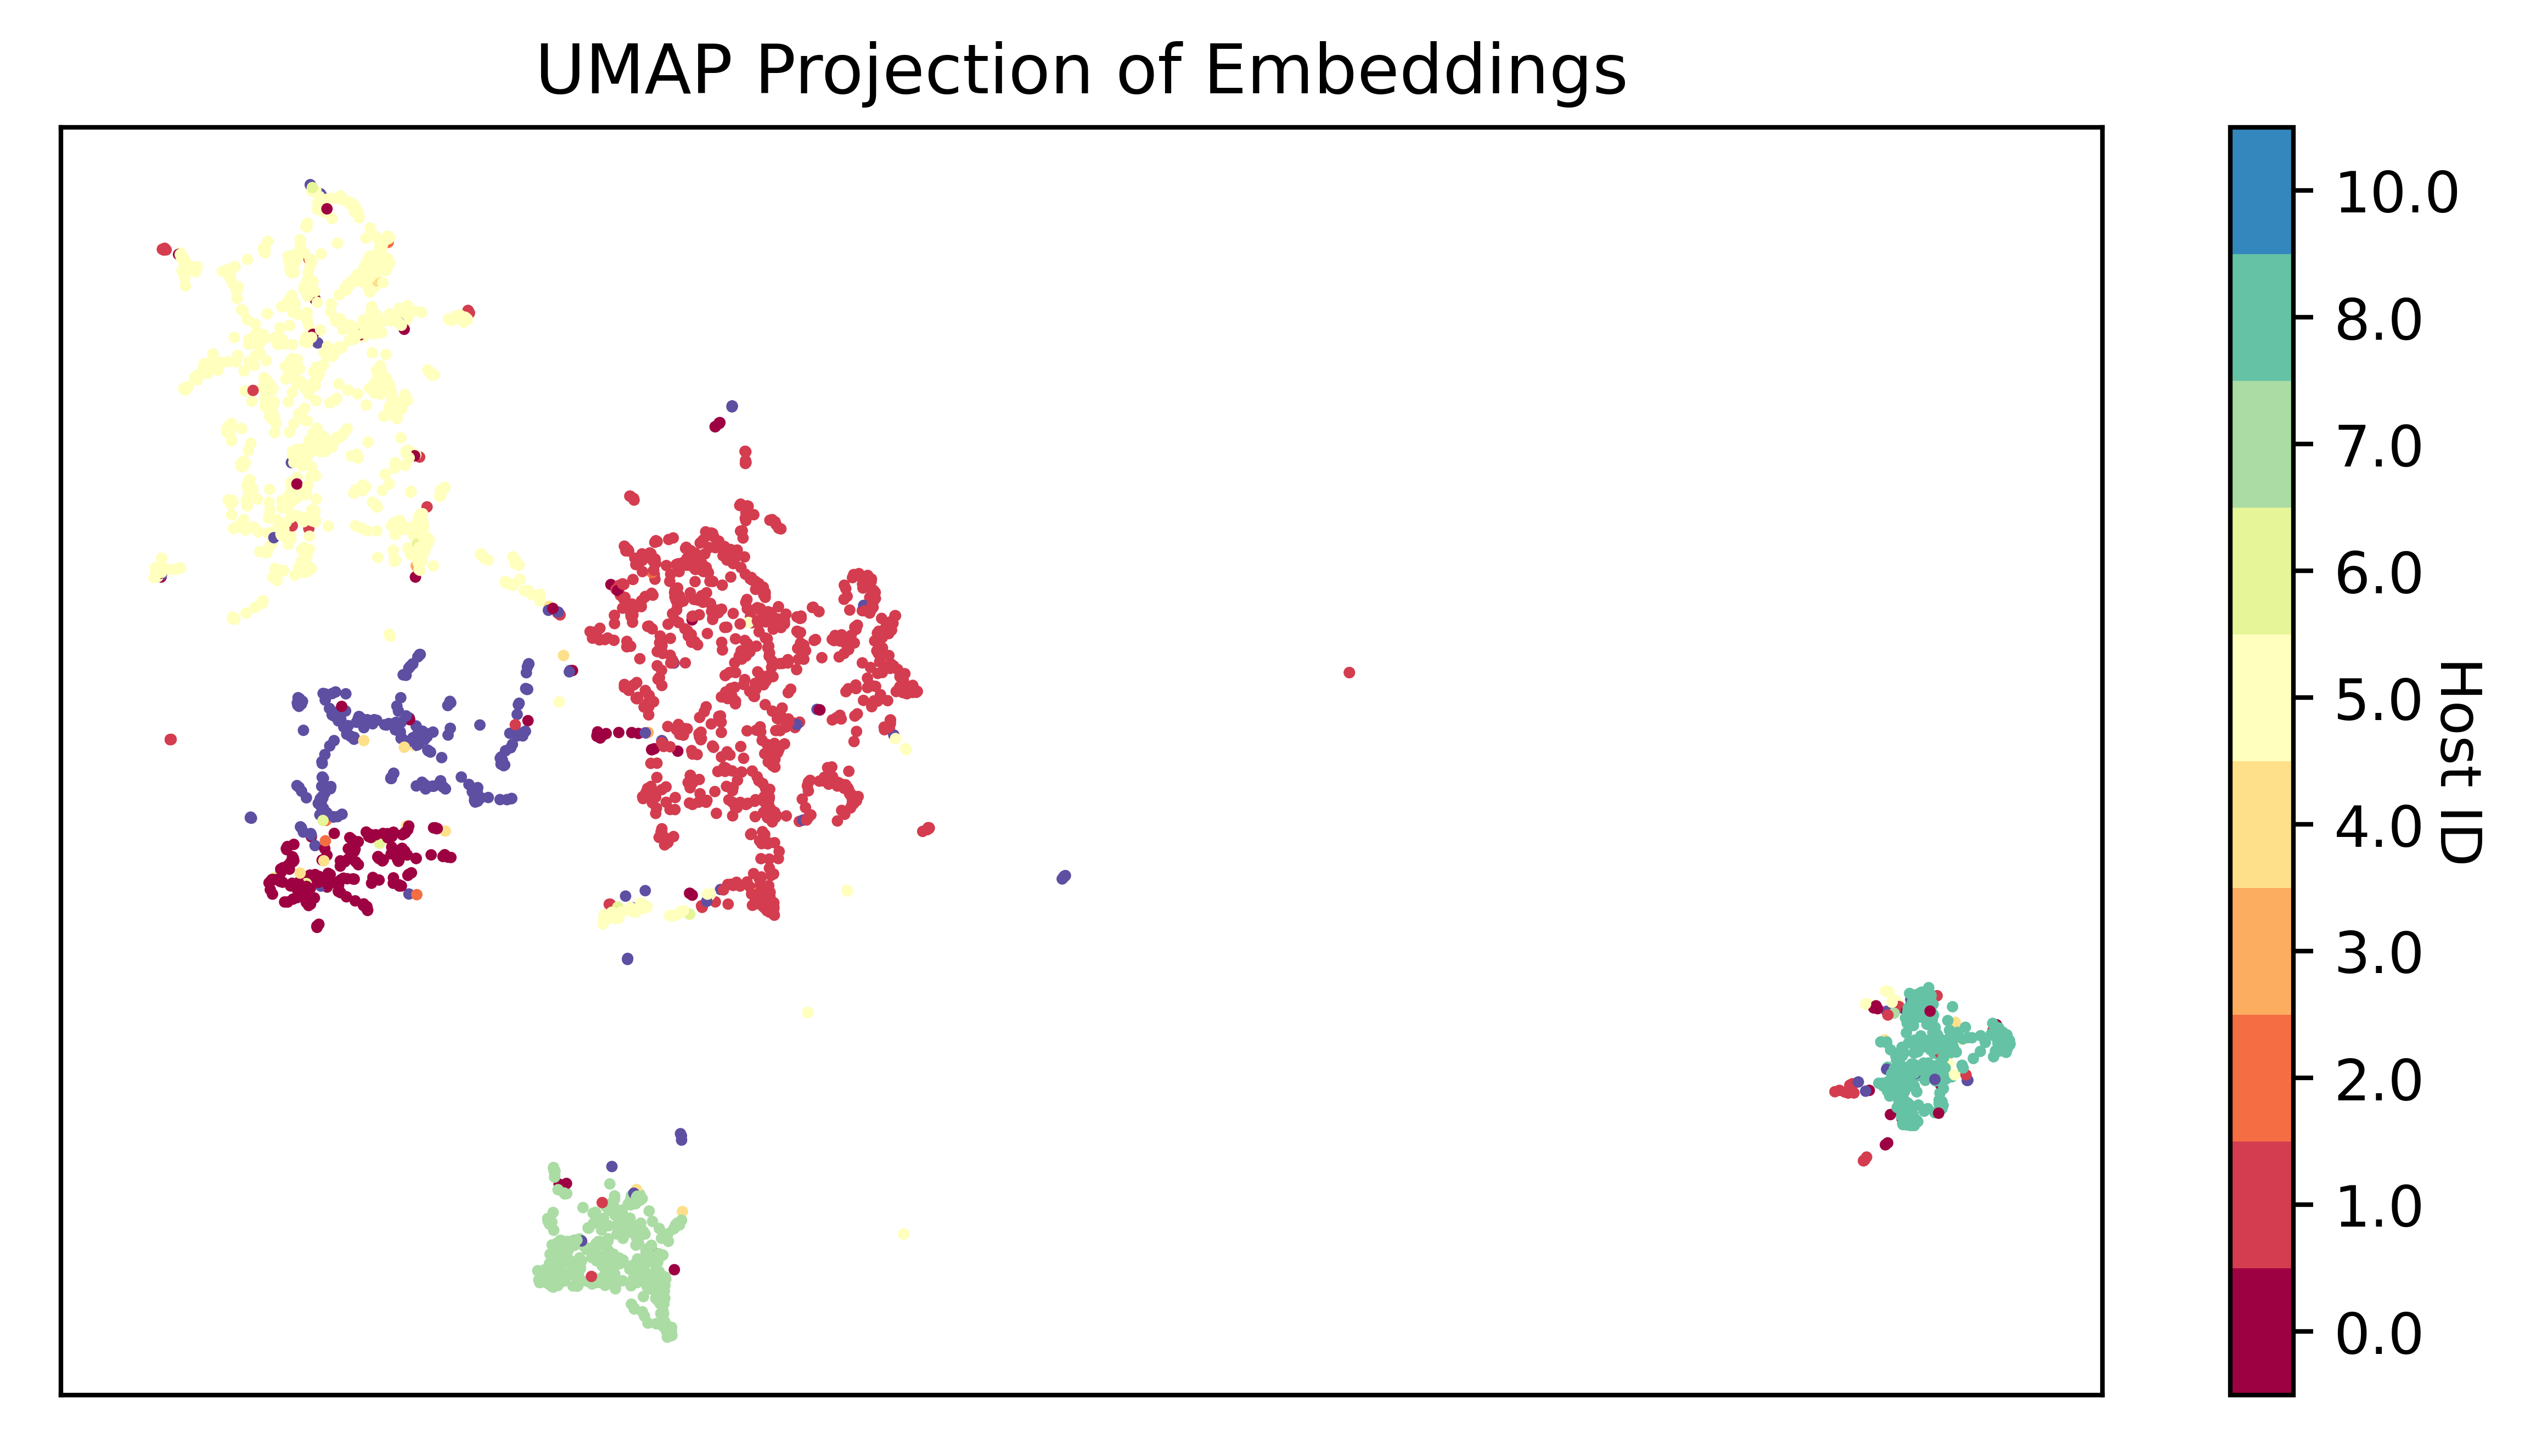

In [90]:
# host_ids = embed_df_with_hosts['host_id'].unique()[:10]
# print(len(host_ids))
# # filter the dataframe to include only the selected hosts
# my_df = embed_df_with_hosts[embed_df_with_hosts['host_id'].isin(host_ids)]
# aX, ay = my_df['embedding'].values, my_df['host_id'].values

# # Split the data into training and testing sets
# aX_train, aX_test, ay_train, ay_test = train_test_split(aX, ay, test_size=0.2, random_state=42)

# # Convert the labels to integers
# ay_train = ay_train.astype(int)
# ay_test = ay_test.astype(int)

# # Convert the lists of floats into numpy arrays
# aX_train = np.array([np.array(x) for x in aX_train])
# aX_test = np.array([np.array(x) for x in aX_test])

# aembedding = umap.UMAP().fit_transform(aX_train)
# aembedding = umap.UMAP().fit_transform(aX_train, ay_train)
plt.figure(figsize=(8, 4), dpi=750)
plt.scatter(*aembedding.T, s=1, c=ay_train, cmap='Spectral', alpha=1.0)
# remove the axes
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.title('UMAP Projection of Embeddings')
# add colorbar
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_label('Host ID', rotation=270)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(host_ids)
plt.show()